<a href="https://colab.research.google.com/github/sutummala/periCellNet/blob/main/periCell_Contrastive_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155225 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
import os
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
#import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold, cross_val_score
import sklearn
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import Image, display
import matplotlib.cm as cm
import cv2

In [ ]:
hel_path = '/content/drive/MyDrive/Datasets/turkey/type1'
all_path = '/content/drive/MyDrive/Datasets/turkey/type2'

In [ ]:
def get_array(path):
  mat = []
  for file in os.listdir(path):
    img = cv2.imread(os.path.join(path, file))
    img = resize(img, (300, 300), anti_aliasing=True)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    mat.append(img*255)
  return np.array(mat)

In [ ]:
healthy_imgs = get_array(hel_path)
all_imgs = get_array(all_path)

In [ ]:
print(np.min(healthy_imgs), np.max(healthy_imgs))
print(np.min(all_imgs), np.max(all_imgs))

0.0 255.0
0.0 255.0


In [ ]:
print(healthy_imgs.shape)
print(all_imgs.shape)

(67, 300, 300, 3)
(29, 300, 300, 3)


In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1-y_true) * square_pred + y_true * margin_square)

In [ ]:
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/periCellNet/siamese_pericell_model_adam_0.001_16_15', custom_objects={'contrastive_loss':contrastive_loss})

In [ ]:
def generate_support_set():

  # Generating random indices for creating Support Set
  hel_index = random.randint(0, np.shape(healthy_imgs)[0]-1)
  all_index = random.randint(0, np.shape(all_imgs)[0]-1)
  
  support_set = np.concatenate((np.expand_dims(healthy_imgs[hel_index, :, :, :], axis=0),
                                np.expand_dims(all_imgs[all_index, :, :, :], axis=0)))

  return support_set



In [ ]:
# 2-way few-shot learning/verification starts here

is_CAM = False

cell_types = ['hel', 'all']

overall_accuracy = 0
true_cell_labels = []
predicted_cell_labels = []
k_shot = 7 # parameter that controls the number of shots

print(f'Doing 2-way {k_shot}-shot classification')

for cells in cell_types:
  if cells == 'hel':
    print(f'calculating accuracy for {cells}')
    cell = healthy_imgs
    cell_labels = np.zeros(np.shape(healthy_imgs)[0])
  elif cells == 'all':
    print(f'calculating accuracy for {cells}')
    cell = all_imgs
    cell_labels = np.ones(np.shape(all_imgs)[0])

  correct_predictions = 0 # Initializing for calculating accuracy
  #true_cell_labels.append(cell_labels)
  for c in range(0, np.shape(cell)[0]-1):

      query_image = np.expand_dims(cell[c, :, :, :], axis=0) # Expanding dimension of the cell image 
      query_images = np.repeat(query_image, repeats = 2, axis = 0) # Making 2 copies of the query image
      #query_images = query_images[:, 30:330, 30:330, :] # doing center cropping
      #query_images = tf.keras.applications.resnet50.preprocess_input(query_images)

      # predicting on a query image
      query_predictions = np.zeros((2, 1))
      for k in range(k_shot): # Doing prediction for k-shot learning
        support_set = generate_support_set() # Generating support-set for k-shot learning, one image for each class label
        #support_set = tf.keras.applications.resnet50.preprocess_input(support_set)
        predictions = siamese_model.predict([query_images, support_set])
        #predictions = siamese_model.predict([tf.image.resize(query_images, [380, 380]), tf.image.resize(support_set, [380, 380])])
        query_predictions += predictions
        
        if is_CAM: # Doing this for one image of each cell type
          plot_L1 = True
          plot_heat_map_low_res = False
          print(f'doing activation mapping for {cells} image shown below')
          plt.imshow(np.squeeze(query_image)) # plotting the query image
          plt.axis('off')
          plt.show()

          for image_index in range(len(query_images)): # This block extracts the L1-norm and do CAM plotting between query and support set images
            print(f'plotting L1_norm and heatmaps for the {cells} query image w.r.t support set image {cell_types[image_index]}')
            Siamese_CAM(query_images[image_index], support_set[image_index], plot_L1, plot_heat_map_low_res)
      
      #print(query_predictions)  
      predicted_label = np.argmin(query_predictions)
      predicted_cell_labels.append(predicted_label)
      true_cell_labels.append(cell_labels[c])
      #print(np.transpose(query_predictions))
      #print(f'actual label is {erythroblast_labels[c]}, predicted label is {predicted_label}')
      if cell_labels[c] == predicted_label:
        correct_predictions += 1
  
  accuracy = correct_predictions/(np.shape(cell)[0]) # Use it for testing 
  #accuracy = correct_predictions/(index) # Use it for validation
  print(f'accuracy for predicting {cells} is {accuracy}')
  overall_accuracy = accuracy + overall_accuracy

overall_accuracy = overall_accuracy/2 # the denominator is the number of labels
print(f'Overall Accuracy is {overall_accuracy}')


Doing 2-way 7-shot classification
calculating accuracy for hel
accuracy for predicting hel is 0.8656716417910447
calculating accuracy for all
accuracy for predicting all is 0.5172413793103449
Overall Accuracy is 0.6914565105506948


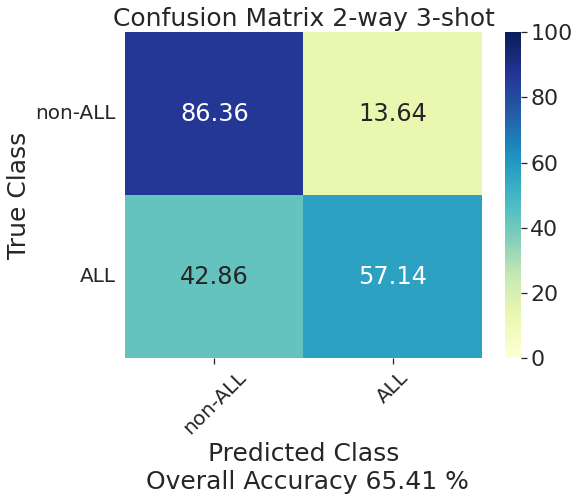

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(true_cell_labels, predicted_cell_labels, normalize = 'true')
class_names = ['non-ALL', 'ALL']
#print(confusion_mat)

# Plotting multilabel confusion matrix in a beautiful manner
sns.set(font_scale=2)
fig = plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(confusion_mat*100, annot=True, vmin = 0, vmax = 100, ax = ax, cmap = 'YlGnBu', fmt = '2.2f'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Class\n Overall Accuracy 65.41 %', fontsize=25)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(class_names, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=25)
ax.yaxis.set_ticklabels(class_names, fontsize = 20)
plt.yticks(rotation=0)

plt.title('Confusion Matrix 2-way 3-shot', fontsize=25)

plt.show()